In [35]:
from OurTrainingTools import *

def test_model(madminermodel, test_input_sm, test_input_bsm, epochs, e, n_meas, pm, verbose_t=True, verbose_period_t=1e5):
        
        def compute_t(madminermodel, nev, counter, test_input):
            n_gen = 0
            while n_gen == 0:
                n_gen = np.random.poisson(nev)
            
            if (counter + n_gen) >= len(test_input):
                return 0., -1
            
            points = test_input[int(counter): int(counter+n_gen)]
            #print('counter = %d, counter+n_gen = %d'%(counter, counter+n_gen))
            #ratio = (madminermodel.evaluate_log_likelihood_ratio(points.cpu().numpy(), 
            #                                np.array([0.]))[0][0])
            log_ratio = (madminermodel.evaluate_log_likelihood_ratio(points.numpy(), 
                                            np.array([0.]))[0][0])
            log_ratio = torch.tensor(log_ratio)
            #ratio = 1./ratio
            log_ratio = -log_ratio
            out  = 2 * (NBSM - NSM - (log_ratio+torch.log(torch.tensor(NBSM/NSM))).sum(0))
            return out, int(counter+n_gen)
        
        test_start = time.time()
        if verbose_t:
            print("NSM = %.3f --- NBSM = %.3f"%(NSM, NBSM))
        tsm  = torch.empty(n_meas)
        tbsm = torch.empty(n_meas)
        
        tsmcount  = torch.zeros(n_meas+1)
        tbsmcount = torch.zeros(n_meas+1)
            
        for i in range(n_meas):
            tsm[i], tsmcount[i+1] = compute_t(madminermodel, NSM, tsmcount[i], 
                                       test_input_sm)
            tbsm[i], tbsmcount[i+1] = compute_t(madminermodel, NBSM, tbsmcount[i], 
                                       test_input_bsm)
            
            if (tsmcount[i+1] < 0) or (tbsmcount[i+1] < 0):
                print('Reaching the end of test data. Stop tests at %d. '%i)
                tsm, tbsm = tsm[: i], tbsm[: i]
                n_meas = i
                break
                
            if i % (verbose_period_t) == 0:
                print('test %s: tsm = %.3f,  tbsm = %.3f'%(
                        str(i).ljust(4), tsm[i], tbsm[i]))
        
        test_duration = time.time() - test_start
        
        mu_sm     = tsm.mean().item()
        mu_bsm    = tbsm.mean().item()
        sigma_sm  = tsm.std().item()
        sigma_bsm = tbsm.std().item()
        med_sm    = tsm.median().item()
        
        sep    = (mu_sm - mu_bsm)/sigma_bsm
        p      = 1.*len([i for i in tbsm if i > med_sm])/len(tsm) 
        #print(len([i for i in tbsm if i>med_sm]))
        delta1 = (p * (1 - p)/n_meas)**0.5
        delta2 = (sigma_sm/sigma_bsm) * np.exp(-((mu_bsm - mu_sm)**2)/(
                2 * sigma_bsm**2))/(2*(n_meas**0.5))
        print('===> delta1 = %.3f, delta2 = %.3f'%(delta1, delta2))
        deltap = (delta1**2 + delta2**2)**0.5
        
        if verbose_t:
            print('p = %.3f +/- %.3f' %(p, deltap))
            print('Separation = %.2f sigmas'%(sep))
            training_properties = 'madminer-carl'
            plot_histogram(tsm, tbsm, int(NSM), int(NBSM), p, deltap, sep, epochs, e, 
                                training_properties, results_path)
            print('Partial test after %d epochs (took %.2f seconds)\n'
                          %(e, test_duration))
            
        
        return tsm, tbsm, NSM, NBSM

In [36]:
def plot_histogram(tsm, tbsm, nsm, nbsm, p, deltap, sep, epochs, 
                   e, training_properties, results_folder):
    mint = torch.min(torch.cat((tsm, tbsm))).item()
    maxt = torch.max(torch.cat((tsm, tbsm))).item()
    
    # for some reason the code complains if i don't detach the variables 
    # from their grad-on versions
    tsm, tbsm = tsm.detach(), tbsm.detach()
    
    bins = np.linspace(mint, maxt, 60)
    plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    plt.hist(tsm,  bins, alpha=0.5, label='SM')
    plt.hist(tbsm, bins, alpha=0.5, label='BSM')
    plt.legend(loc='upper right')
    
    sn   = 'nsm = %s \nnbsm = %s'%(str(nsm), str(nbsm))
    sp   = 'p      '+'= '+ ('%.3f +/- %.3f'%(p, deltap))
    ssep = 'sep   ' + '= ' + ('%.3f'%(sep))
    
    plt.text(x=0.05, y=0.85, transform=ax.transAxes, 
         s=sn+'\n'+sp+'\n'+ssep, bbox=dict(facecolor='blue', alpha=0.2))
    plt.xlabel('t')
    plt.ylabel('p(t)')
    if epochs == e:
        plt.title('Final test\n' + training_properties)
        filename = results_folder + training_properties \
                    + ' histogram.pdf'
        plt.savefig(filename)
        return 
    plt.title(training_properties)
    plt.show()
    plt.close()
    
    return

In [53]:
f = h5py.File('gphi_toydata_test.h5', 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

In [54]:
Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

In [55]:
from madminer import ParameterizedRatioEstimator
from madminer.ml.morphing_aware import MorphingAwareRatioEstimator

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/../data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/../models/carl')

NSM = 2225.504 --- NBSM = 2268.608
test 0   : tsm = -1276.041,  tbsm = -1259.756
Reaching the end of test data. Stop tests at 219. 
===> delta1 = 0.033, delta2 = 0.034
p = 0.406 +/- 0.048
Separation = 0.21 sigmas
Partial test after 1 epochs (took 39.68 seconds)



(tensor([-1276.0410, -1220.8379, -1248.2072, -1287.3374, -1318.2161, -1256.9709,
         -1253.4656, -1241.1031, -1237.2832, -1222.1443, -1241.4623, -1230.4718,
         -1310.9475, -1304.5854, -1229.3795, -1248.2072, -1248.0135, -1324.0173,
         -1246.4031, -1251.9304, -1256.6692, -1227.6031, -1279.3851, -1296.2208,
         -1245.3977, -1316.6971, -1302.5950, -1268.6848, -1298.7844, -1254.1051,
         -1193.0811, -1263.6775, -1232.8286, -1232.5549, -1268.5715, -1271.6439,
         -1227.5846, -1218.5172, -1267.4984, -1290.0293, -1273.0380, -1253.2297,
         -1277.7350, -1289.8777, -1311.9749, -1249.8839, -1260.5010, -1214.0386,
         -1268.1536, -1245.7722, -1162.7466, -1267.4000, -1246.7098, -1341.6688,
         -1266.3912, -1307.5779, -1258.0551, -1254.6152, -1292.7590, -1272.9376,
         -1270.3239, -1191.7057, -1273.6655, -1199.5142, -1230.5918, -1185.1412,
         -1242.7909, -1363.1633, -1226.8666, -1297.0123, -1290.5959, -1245.6270,
         -1237.5653, -1259.0

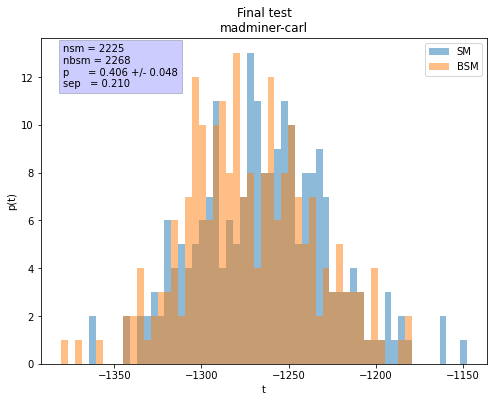

In [56]:
test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', verbose_t=True, verbose_period_t=1e5)

In [52]:
f.close()

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = -1112.106,  tbsm = -1313.560
Reaching the end of test data. Stop tests at 176. 
===> delta1 = 0.011, delta2 = 0.006
p = 0.023 +/- 0.013
Separation = 1.83 sigmas
Partial test after 1 epochs (took 35.57 seconds)



(tensor([-1112.1058, -1123.5297, -1148.6547, -1122.7428, -1178.8881, -1146.5548,
         -1157.0558, -1097.6066, -1142.7694, -1040.5787, -1115.5048, -1145.5758,
         -1041.0616, -1137.3480, -1143.0831, -1134.9108, -1129.6674, -1235.2115,
         -1158.2455, -1181.9056, -1066.1537, -1020.3978, -1061.2572, -1184.9791,
         -1242.8258, -1119.3732, -1205.6305, -1077.8121, -1046.6683, -1182.8334,
         -1162.6188, -1153.6459, -1123.1324, -1146.7906, -1033.8031, -1145.8778,
         -1211.6136, -1199.8802, -1151.2345, -1176.5868, -1037.7858, -1158.5367,
          -952.5375, -1077.3121, -1035.8392, -1123.8929, -1153.3075, -1137.0453,
         -1013.7953, -1221.8363, -1186.0192, -1176.7177, -1033.6588, -1186.1686,
         -1152.0536, -1157.1779, -1218.3026, -1155.7758, -1028.2985, -1168.9833,
         -1093.3898, -1044.7457, -1070.4503, -1134.1913, -1049.7926, -1084.3265,
         -1109.8199, -1155.1573, -1144.3024, -1092.9242, -1128.6259, -1177.7401,
         -1068.1447, -1137.5

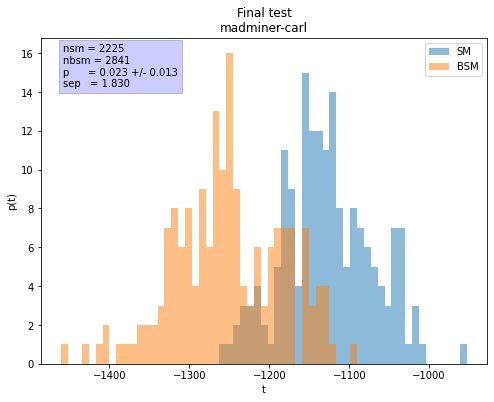

In [57]:
f = h5py.File('gphi_toydata_test_indata.h5', 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])

NBSM = NBSMList[0]

n_epochs = int(1e2)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])

from madminer import ParameterizedRatioEstimator
from madminer.ml.morphing_aware import MorphingAwareRatioEstimator

test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', verbose_t=True, verbose_period_t=1e5)

In [58]:
f.close()